In [7]:
from l0pca.ross import bidiagonal_reference, dense_blocks
import numpy as np
import matplotlib.colors
import matplotlib.pyplot as plt

In [72]:
mat = bidiagonal_reference.sparse_to_dense(dense_blocks.new_random_matrices(1, 7))

# Ross Augmented Singular Values

We have a subproblem SVD singular values (n-1) diagonal matrix. Then, we want to append to the data matrix. There is one dense column (norm of the projection of new data onto the subproblem singular vectors). The new diagonal represents a new orthogonal singular vector, and the norm of the new data along the orthogonalized basis vector.

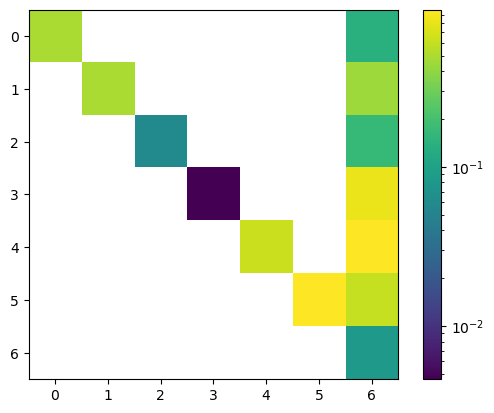

In [12]:
plt.imshow(mat[0], norm=matplotlib.colors.LogNorm())
plt.colorbar()

# Bidiagonal Matrix

This is an example schematic of the expected matrix. We use a decomposition A = U * B * V where B is bidiagonal.

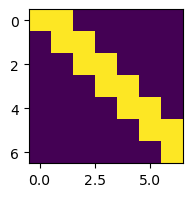

In [22]:
n = 7
schematic = np.eye(n)
schematic[np.arange(n - 1), np.arange(1, n)] = 1
plt.figure(figsize=(2, 2))
plt.imshow(schematic)

# Orthogonal Transformations

Start with U and V as identity, and apply a 2D rotation to either adjacent rows element-wise, or adjacent columns element-wise. Our first goal is to rotate A_1n and A_2n so that A_1n goes to zero (starting to sparsify the appended dense column, and starting from the end that is far from the main diagonal). This is a rotation matrix that is applied elementwise to each column of A, so it must be multiplied on the LHS.

As a side effect, we densified a 2x2 square along the diagonal, which are going to clean up next. In general, our data columns and singular values are already unique, so we are not going to get any cancellations. When we apply a rotation matrix to zero out one entry, any dimension that had only one entry along that location will now have both entries nonzero.

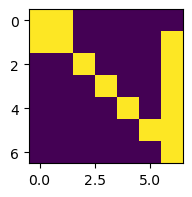

In [23]:
schematic = np.eye(n)
schematic[1:6, -1] = 1
schematic[0:2, 0:2] = 1
plt.figure(figsize=(2, 2))
plt.imshow(schematic)

# Termination

Clean up the diagonal, and keep the upper off-diagonal, using a rotation matrix from the RHS. We plan a rotation on entries A_21 and A_22, and then it is applied to every row in turn. We will see below that there will be intermediate steps between modifying the dense augmented column, and reaching this termination subroutine in the inner loop.

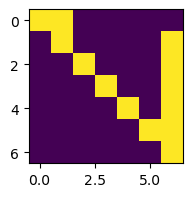

In [24]:
schematic = np.eye(n)
schematic[1:6, -1] = 1
schematic[0, 1] = 1
plt.figure(figsize=(2, 2))
plt.imshow(schematic)

# Initialize Next Diagonal

The LHS rotation will always work similarly to the first one. We'll start highlighting the entries that are read and written on the current step. We will write back to the sparse storage (diagonal array, off-diagonal +1 array, augmented column array). We finish this operation immediately because it will take more than one step to resolve the element that is on the off-diagonal -1.

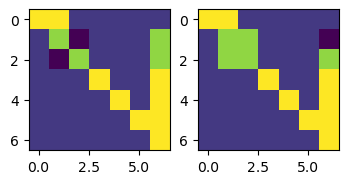

In [45]:
plt.figure(figsize=(4, 2))
schematic = np.eye(n)
schematic[1:6, -1] = 1
schematic[0, 1] = 1
schematic[1:3, 1:3] -= 0.2
schematic[1:3, -1] -= 0.2
plt.subplot(1, 2, 1)
plt.imshow(schematic)
plt.subplot(1, 2, 2)
schematic[1, -1] -= 1
schematic[1, 2] += 1
schematic[2, 1] += 1
plt.imshow(schematic)

# Inner Loop

Now, we start slicing 3 data rows into our storage on each read/write, because the number of nonzero entries in the current column has increased. We apply an RHS rotation where columns 2 and 3 are non-identity, followed by an LHS rotation where rows 1 and 2 are non-identity. Write the 3 rows of data back, and decrement an inner loop counter by 1 until the local variable (off-diagonal entry storage) reaches row 2. Then, we can apply the termination subroutine.

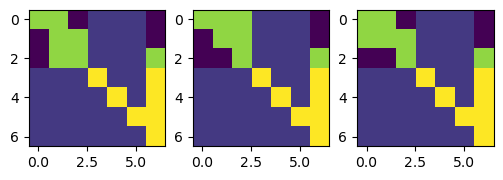

In [55]:
plt.figure(figsize=(6, 2))
schematic = np.eye(n)
schematic[2:6, -1] = 1
schematic[range(0, 2), range(1, 3)] = 1
schematic[2, 1] = 1
schematic[0:3, 0:3] -= 0.2
schematic[0:3, -1] -= 0.2
plt.subplot(1, 3, 1)
plt.imshow(schematic)
plt.subplot(1, 3, 2)
schematic[2, 1] -= 1
schematic[0, 2] += 1
plt.imshow(schematic)
plt.subplot(1, 3, 3)
schematic[0, 2] -= 1
schematic[1, 0] += 1
plt.imshow(schematic)

# Time Complexity

For convenience purposes, this scheme uses O(1) additional storage and O(n^2) time (for each row in turn to become bidiagonalized, the number of operations ramps up from ~1 to ~n).

With increased code complexity, we could permit 2 of the localy modified entries which we described (which are on either the -1 off-diagonal or the +2 off-diagonal) to coexist. Then, we would probably find a way to rotate one such cell down to zero without making any new cell nonzero (reducing the number of non-bidiagonal entries from n to n - 1). This could improve time complexity to O(n). However, when computing this SVD subproblem, we have always started with a main matrix which is O(m * n), and we usually choose n as the smaller dimension, so we accept O(n^2) time complexity here.

# Reference Implementation

NumPy arrays were chosen for a reference implementation because they are mutable. In TensorFlow, making many inner-loop updates in matrix form may cut into performance gains on more typical projects. The packed slices of immutable data that are sliced out in the production TensorFlow implementation will be documented elsewhere.

In [106]:
import importlib
bidiagonal_reference = importlib.reload(bidiagonal_reference)
mat = bidiagonal_reference.sparse_to_dense(dense_blocks.new_random_matrices(1, 7))

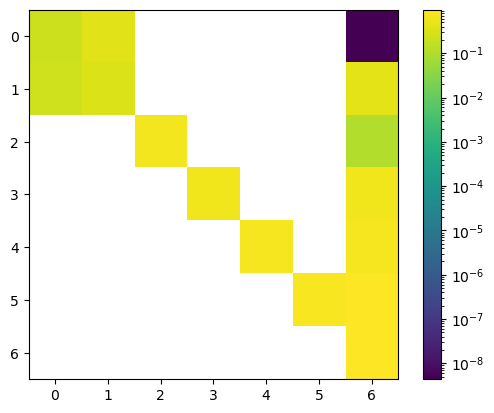

In [107]:
mat = bidiagonal_reference.update_augmented(mat, 0)
plt.imshow(np.abs(mat[0, :, :]), norm=matplotlib.colors.LogNorm())
plt.colorbar()

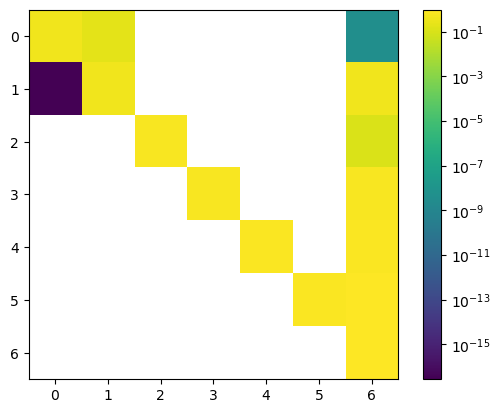

In [108]:
mat = bidiagonal_reference.terminate_temp_value(mat)
plt.imshow(np.abs(mat[0, :, :]), norm=matplotlib.colors.LogNorm())
plt.colorbar()

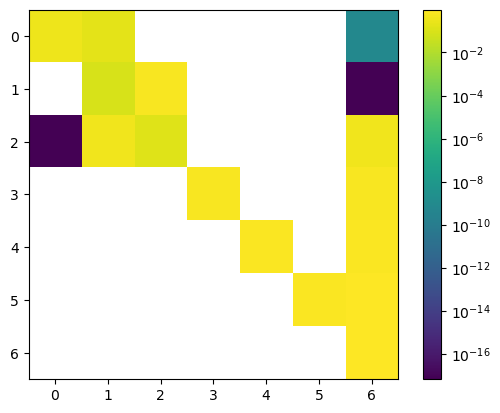

In [109]:
mat = bidiagonal_reference.update_augmented(mat, 1)
plt.imshow(np.abs(mat[0, :, :]), norm=matplotlib.colors.LogNorm())
plt.colorbar()

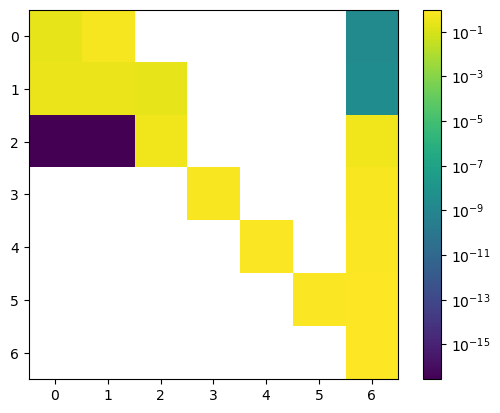

In [110]:
mat = bidiagonal_reference.step_temp_cell(mat, 2, 1)
plt.imshow(np.abs(mat[0, :, :]), norm=matplotlib.colors.LogNorm())
plt.colorbar()

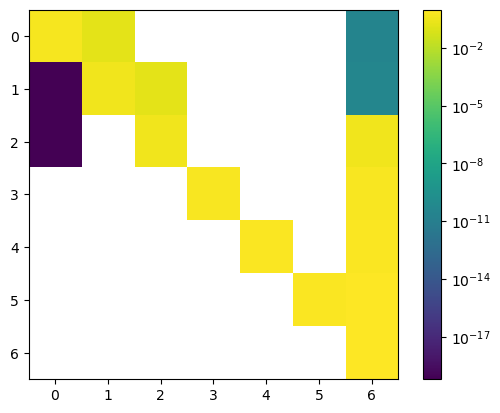

In [111]:
mat = bidiagonal_reference.terminate_temp_value(mat)
plt.imshow(np.abs(mat[0, :, :]), norm=matplotlib.colors.LogNorm())
plt.colorbar()